# Lab-06 : Softmax Classification

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.manual_seed(1)

## 1) 파이토치로 소프트맥스의 비용 함수 구현하기_(로우-레벨)

In [30]:
z = torch.FloatTensor([1, 2, 3])

hypothesis = F.softmax(z, dim=0)
print(hypothesis)
print("원소의 총합 :", hypothesis.sum().item())

tensor([0.0900, 0.2447, 0.6652])
원소의 총합 : 1.0


In [31]:
# 임의의 예측값 생성
z = torch.rand(3, 5, requires_grad=True)

hypothesis = F.softmax(z, dim=1) # dim=1 : 각 행의 합이 1, dim=0 : 각 열의 합이 1
print(hypothesis)

tensor([[0.2051, 0.1801, 0.2572, 0.1524, 0.2051],
        [0.2130, 0.1596, 0.2129, 0.1637, 0.2507],
        [0.2571, 0.1576, 0.1595, 0.1524, 0.2734]], grad_fn=<SoftmaxBackward0>)


In [32]:
# 임의의 레이블(정답) 생성
y = torch.randint(5, (3,)).long()
print(y)

tensor([2, 3, 1])


In [44]:
# 레이블에 대한 원-핫 인코딩
y_one_hot = torch.zeros_like(hypothesis) # 모든 원소가 0의 값을 가진 3 × 5 텐서 생성
print(y_one_hot)
y_one_hot.scatter_(1, y.unsqueeze(1), 1) # y텐서의크기가 (3,) -> (3 x 1)텐서가 됨

print(y.unsqueeze(1))
print(y_one_hot)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[2],
        [3],
        [1]])
tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.]])


In [ ]:
# 비용함수
cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean() # (3, 5) -> (3, ) -> scalar
print(cost)

tensor(1.5665, grad_fn=<MeanBackward0>)


## 2) 파이토치로 소프트맥스의 비용 함수 구현하기_(하이-레벨)

- F.log_softmax() : 소프트맥스함수에 로그를 취한 값 출력
- F.cross_entropy() : 비용 함수에 소프트맥스 함수까지 포함하고 있음을 기억하고 있어야 구현 시 혼동하지 않음

### (1) F.softmax() + torch.log() = F.log_softmax()

In [ ]:
F.log_softmax(z, dim=1)

tensor([[-1.4715, -1.9264, -1.8288, -1.4211, -1.5020],
        [-1.9149, -1.8536, -1.2443, -1.7947, -1.4203],
        [-1.4439, -1.9836, -2.0857, -1.1805, -1.6343]],
       grad_fn=<LogSoftmaxBackward0>)

### (2) F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [ ]:
F.cross_entropy(z, y)

tensor(1.5665, grad_fn=<NllLossBackward0>)

## 3) 소프트맥스 회귀 구현하기

In [ ]:
# 데이터 준비
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [ ]:
# 클래스의 개수가 3개 -> y_train 원-핫 인코딩한 결과 (8 × 3)이어야 함
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)

print(y_one_hot.shape)

torch.Size([8, 3])


### (1) 소프트맥스 회귀 구현하기(로우-레벨)

In [ ]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

# 학습
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1)

    # 비용 함수
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704199
Epoch  200/1000 Cost: 0.622999
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467661
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285072
Epoch 1000/1000 Cost: 0.248155


### (2) 소프트맥스 회귀 구현하기(하이-레벨)

In [ ]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros((1, 3), requires_grad=True)

# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.704199
Epoch  200/1000 Cost: 0.623000
Epoch  300/1000 Cost: 0.565717
Epoch  400/1000 Cost: 0.515291
Epoch  500/1000 Cost: 0.467662
Epoch  600/1000 Cost: 0.421278
Epoch  700/1000 Cost: 0.375402
Epoch  800/1000 Cost: 0.329766
Epoch  900/1000 Cost: 0.285073
Epoch 1000/1000 Cost: 0.248155


### (3) 소프트맥스 회귀 nn.Module로 구현하기

-  output_dim이 1이었던 선형 회귀때와 달리 output_dim은 이제 클래스의 개수여야 함.

In [ ]:
# 모델 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.623715
Epoch  100/1000 Cost: 0.674488
Epoch  200/1000 Cost: 0.604830
Epoch  300/1000 Cost: 0.550380
Epoch  400/1000 Cost: 0.501026
Epoch  500/1000 Cost: 0.453883
Epoch  600/1000 Cost: 0.407730
Epoch  700/1000 Cost: 0.361971
Epoch  800/1000 Cost: 0.316510
Epoch  900/1000 Cost: 0.272799
Epoch 1000/1000 Cost: 0.242195


### (4) 소프트맥스 회귀 클래스로 구현하기

In [ ]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

model = SoftmaxClassifierModel()

# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 3.958492
Epoch  100/1000 Cost: 0.721100
Epoch  200/1000 Cost: 0.635464
Epoch  300/1000 Cost: 0.577201
Epoch  400/1000 Cost: 0.526544
Epoch  500/1000 Cost: 0.478897
Epoch  600/1000 Cost: 0.432573
Epoch  700/1000 Cost: 0.386783
Epoch  800/1000 Cost: 0.341179
Epoch  900/1000 Cost: 0.296093
Epoch 1000/1000 Cost: 0.255489


# Lab-07-1 : Tips

## 1) Training and Test Dataset

In [ ]:
# 데이터 준비
x_train = [[1, 2, 1],
           [1, 3, 2],
           [1, 3, 4],
           [1, 5, 5],
           [1, 7, 5],
           [1, 2, 5],
           [1, 6, 6],
           [1, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

print(x_train.shape)
print(y_train.shape)

torch.Size([8, 3])
torch.Size([8])


In [ ]:
x_test = torch.FloatTensor([[2, 1, 1], [3, 1, 2], [3, 3, 1]])
y_test = torch.LongTensor([2, 2, 2])

In [ ]:
# 모델 설정
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 3)
    def forward(self, x):
        return self.linear(x)

model = SoftmaxClassifierModel()

In [ ]:
# Optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
# Training
def train(model, optimizer, x_train, y_train):
    nb_epochs = 20
    for epoch in range(nb_epochs):
        # H(x) 계산
        prediction = model(x_train)

        #Cost 계산
        cost = F.cross_entropy(prediction, y_train)

        # coat로 H(x) 개선
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        print("Epoch {:4d}/{} Cost: {:.6f}".format(
            epoch, nb_epochs, cost.item()
        ))

In [ ]:
# Test(Validation)
def test(model, optimizer, x_test, y_test):
    prediction = model(x_test)
    predicted_classes = prediction.max(1)[1]
    correct_count = (predicted_classes == y_test).sum().item()
    cost = F.cross_entropy(prediction, y_test)

    print("Accuracy: {}% Cost: {:.6f}".format(
        correct_count/len(y_test)*100, cost.item()
    ))

In [ ]:
# 학습
train(model, optimizer, x_train, y_train)

Epoch    0/20 Cost: 0.579925
Epoch    1/20 Cost: 0.578894
Epoch    2/20 Cost: 0.577891
Epoch    3/20 Cost: 0.576914
Epoch    4/20 Cost: 0.575963
Epoch    5/20 Cost: 0.575035
Epoch    6/20 Cost: 0.574130
Epoch    7/20 Cost: 0.573246
Epoch    8/20 Cost: 0.572382
Epoch    9/20 Cost: 0.571538
Epoch   10/20 Cost: 0.570711
Epoch   11/20 Cost: 0.569902
Epoch   12/20 Cost: 0.569109
Epoch   13/20 Cost: 0.568332
Epoch   14/20 Cost: 0.567569
Epoch   15/20 Cost: 0.566821
Epoch   16/20 Cost: 0.566085
Epoch   17/20 Cost: 0.565362
Epoch   18/20 Cost: 0.564651
Epoch   19/20 Cost: 0.563952


In [ ]:
# 평가
test(model, optimizer, x_test, y_test)

Accuracy: 100.0% Cost: 0.004440


## 2) Data Preprocessing

In [ ]:
# 데이터 준비
x_train = torch.FloatTensor([[73, 80, 75],
                             [93, 88, 93],
                             [89, 91, 90],
                             [96, 98, 100],
                             [73, 66, 70]])
y_train = torch.FloatTensor([[152], [185], [180], [196], [142]])

print(x_train.shape)
print(y_train.shape)

torch.Size([5, 3])
torch.Size([5, 1])


In [ ]:
# Standardization
mu = x_train.mean(dim=0)
sigma = x_train.std(dim=0)

norm_x_train = (x_train - mu) / sigma
print(norm_x_train)

tensor([[-1.0674, -0.3758, -0.8398],
        [ 0.7418,  0.2778,  0.5863],
        [ 0.3799,  0.5229,  0.3486],
        [ 1.0132,  1.0948,  1.1409],
        [-1.0674, -1.5197, -1.2360]])


In [ ]:
class MultivariateLinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)
    def forward(self, x):
        return self.linear(x)

model = MultivariateLinearRegressionModel()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)

In [ ]:
# Training
def train(model, optimizer, x_train, y_train):
    nb_epochs = 20
    for epoch in range(nb_epochs):
        # H(x) 계산
        prediction = model(x_train)

        #Cost 계산
        cost = F.mse_loss(prediction, y_train)

        # coat로 H(x) 개선
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        print("Epoch {:4d}/{} Cost: {:.6f}".format(
            epoch, nb_epochs, cost.item()
        ))

In [ ]:
# 정규화 전 데이터
train(model, optimizer, x_train, y_train)

Epoch    0/20 Cost: 78276.554688
Epoch    1/20 Cost: 1515633115136.000000
Epoch    2/20 Cost: 29347553040131948544.000000
Epoch    3/20 Cost: 568263609532877321967501312.000000
Epoch    4/20 Cost: 11003420135667788290398666472030208.000000
Epoch    5/20 Cost: inf
Epoch    6/20 Cost: inf
Epoch    7/20 Cost: inf
Epoch    8/20 Cost: inf
Epoch    9/20 Cost: inf
Epoch   10/20 Cost: inf
Epoch   11/20 Cost: inf
Epoch   12/20 Cost: nan
Epoch   13/20 Cost: nan
Epoch   14/20 Cost: nan
Epoch   15/20 Cost: nan
Epoch   16/20 Cost: nan
Epoch   17/20 Cost: nan
Epoch   18/20 Cost: nan
Epoch   19/20 Cost: nan


In [ ]:
# 정규화 후 데이터
train(model, optimizer, norm_x_train, y_train)

Epoch    0/20 Cost: 29593.488281
Epoch    1/20 Cost: 18790.857422
Epoch    2/20 Cost: 11982.956055
Epoch    3/20 Cost: 7656.681152
Epoch    4/20 Cost: 4896.819824
Epoch    5/20 Cost: 3133.111816
Epoch    6/20 Cost: 2005.090576
Epoch    7/20 Cost: 1283.371826
Epoch    8/20 Cost: 821.529602
Epoch    9/20 Cost: 525.963989
Epoch   10/20 Cost: 336.800964
Epoch   11/20 Cost: 215.733078
Epoch   12/20 Cost: 138.244537
Epoch   13/20 Cost: 88.646927
Epoch   14/20 Cost: 56.899635
Epoch   15/20 Cost: 36.576534
Epoch   16/20 Cost: 23.565197
Epoch   17/20 Cost: 15.233502
Epoch   18/20 Cost: 9.896955
Epoch   19/20 Cost: 6.477475


# Lab-07-2 : MNIST Introduction

- torchvision : 유명한 데이터셋과 아키텍처, 트랜스폼들이 들어있는 모듈
- ToTensor() : 이미지 데이터를 파이토치 형식에 맞게 변경해주는 트랜스폼

In [18]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [19]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [20]:
# hyperparameters
training_epochs = 15
batch_size = 100

In [23]:
# 데이터 준비
mnist_train = dsets.MNIST(root="MNIST_data/", train=True,
                          transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root="MNIST_data/", train=False,
                          transform=transforms.ToTensor(), download=True)

# 데이터로더
data_loader = DataLoader(dataset=mnist_train, batch_size=batch_size,
                         shuffle=True, drop_last=True)

In [27]:
# MNIST data image of shape 28 * 28 = 784
# to() : 연산을 어디서 수행할지 정하고 모델의 매개변수를 지정한 장치의 메모리로 보냄
linear = nn.Linear(784, 10, bias=True).to(device)

# 비용 함수와 옵티마이저 정의
# nn.CrossEntropyLoss() = nn.functional.cross_entropy()
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수 포함
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [28]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # X : (배치 크기 × 1 × 28 × 28) -> view를 통해 (배치 크기 × 784)로 변환
        X = X.view(-1, 28 * 28).to(device) # (100, 784) 텐서
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.534790695
Epoch: 0002 cost = 0.358537644
Epoch: 0003 cost = 0.330809742
Epoch: 0004 cost = 0.315893680
Epoch: 0005 cost = 0.306985825
Epoch: 0006 cost = 0.300016910
Epoch: 0007 cost = 0.294956148
Epoch: 0008 cost = 0.290699542
Epoch: 0009 cost = 0.287324280
Epoch: 0010 cost = 0.284420669
Epoch: 0011 cost = 0.281920254
Epoch: 0012 cost = 0.279514104
Epoch: 0013 cost = 0.277719915
Epoch: 0014 cost = 0.275916904
Epoch: 0015 cost = 0.274499744
Learning finished


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.8816999793052673
Label:  9
Prediction:  9


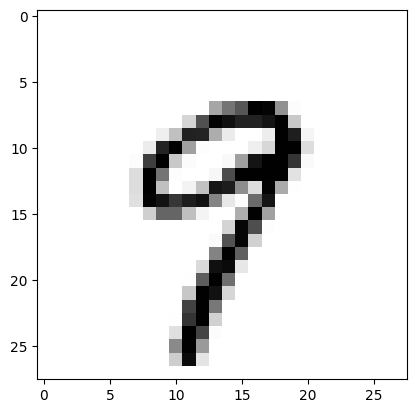

In [29]:
# 모델 테스트
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않음
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()